In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
def edit(filepath):
    #read the cv file
    df = pd.read_csv(filepath)
    
    # Combine Date and Time
    df["ds"] = pd.to_datetime(df["date"] + " " + df["datetime"],format="%m/%d/%Y %H:%M.%S", errors="coerce")

    # Rename columns for Prophet
    df.rename(columns={"money": "y"}, inplace=True)
    
    #drop unecesary row in ds NaT
    df = df.dropna(subset=["ds"])

    #drop columns 
    df.drop(columns=[
        "date",
        "datetime",
        "cash_type",
        "card",
        "coffee_name"
    ],inplace = True)

    #set ds as index
    df = df.set_index("ds")
    return df

In [3]:
df = edit("C:/Users/HP/Documents/ML and AI/train_data_coffee.csv")
df.head(5)

,y
ds,
2024-03-01 15:50:05,38.7
2024-03-01 19:22:05,38.7
2024-03-01 20:18:01,38.7
2024-03-01 19:02:08,38.7
2024-03-01 22:01:08,38.7


In [4]:
df.shape

(1379, 1)

**Exploring the data**

<Axes: title={'center': 'Distribution of Price'}>

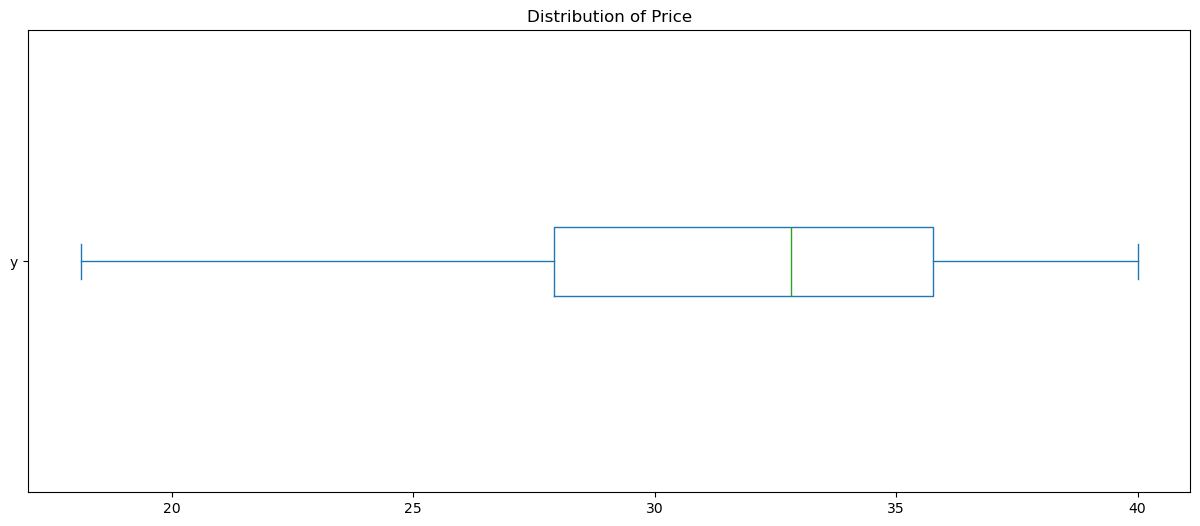

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
df["y"].plot(kind="box",vert=False,title="Distribution of Price",ax=ax)

Resampling the data to see trends 

In [6]:
#daily
daily_df = df.resample("d").sum()  # Sum of sales per day
print(daily_df.head())

                y
ds               
2024-03-01  227.3
2024-03-02   28.9
2024-03-03  252.6
2024-03-04   96.5
2024-03-05   38.7


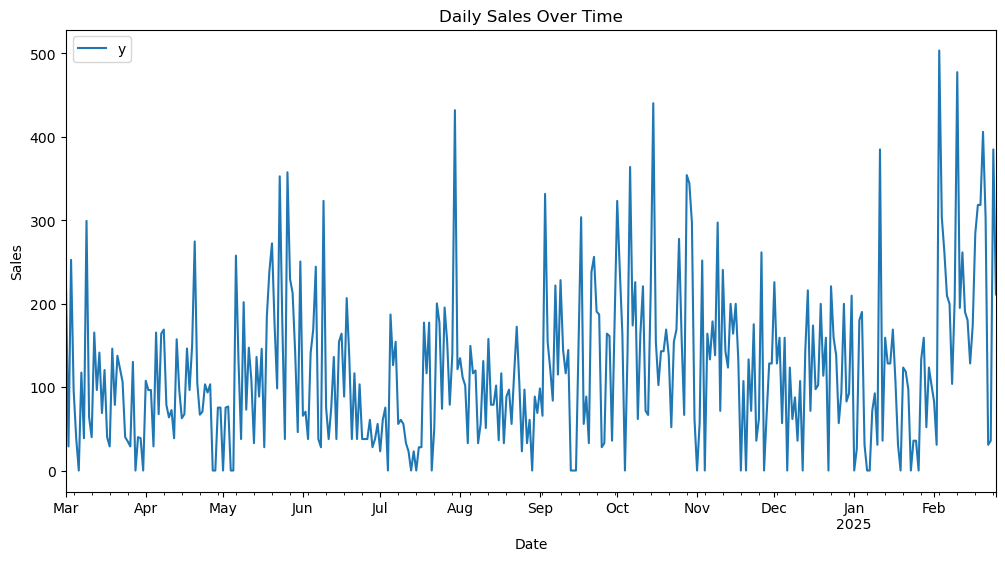

In [7]:
daily_df.plot(figsize=(12,6), title="Daily Sales Over Time", ylabel="Sales", xlabel="Date")
plt.show()


In [8]:
#weekly
weekly_df = df.resample("W").sum()

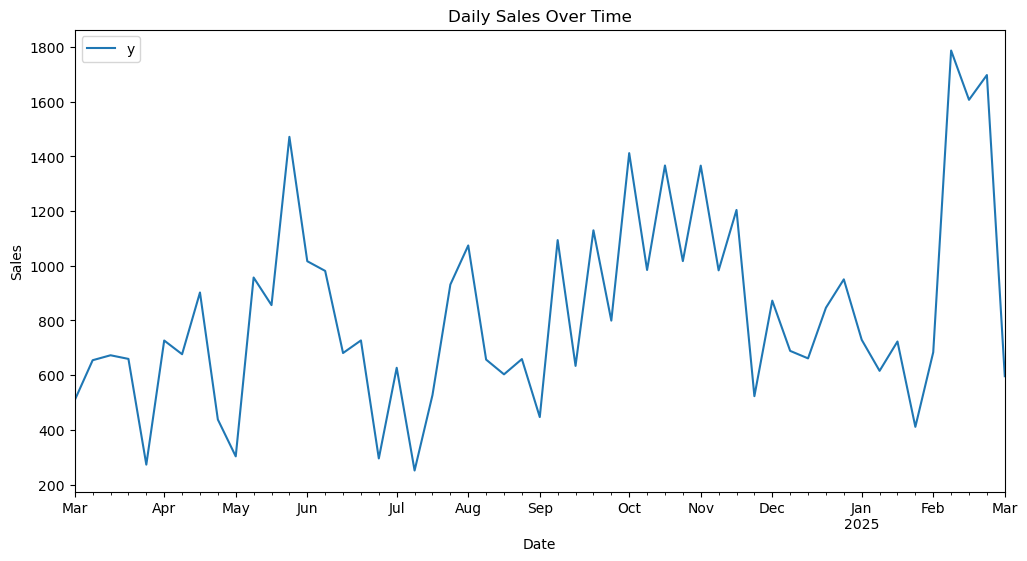

In [9]:
weekly_df.plot(figsize=(12,6), title="Daily Sales Over Time", ylabel="Sales", xlabel="Date")
plt.show()


In [10]:
#hourly
Monthly_df = df.resample("ME").sum()

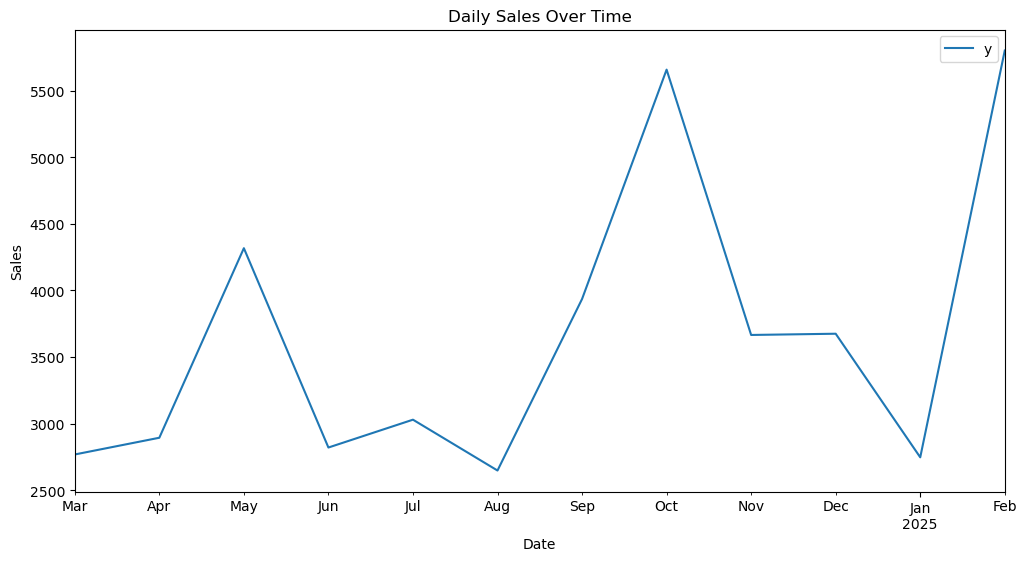

In [11]:
Monthly_df.plot(figsize=(12,6), title="Daily Sales Over Time", ylabel="Sales", xlabel="Date")
plt.show()


##### my data is normally distributed 

**Exploring my data using Pacf and ACF**

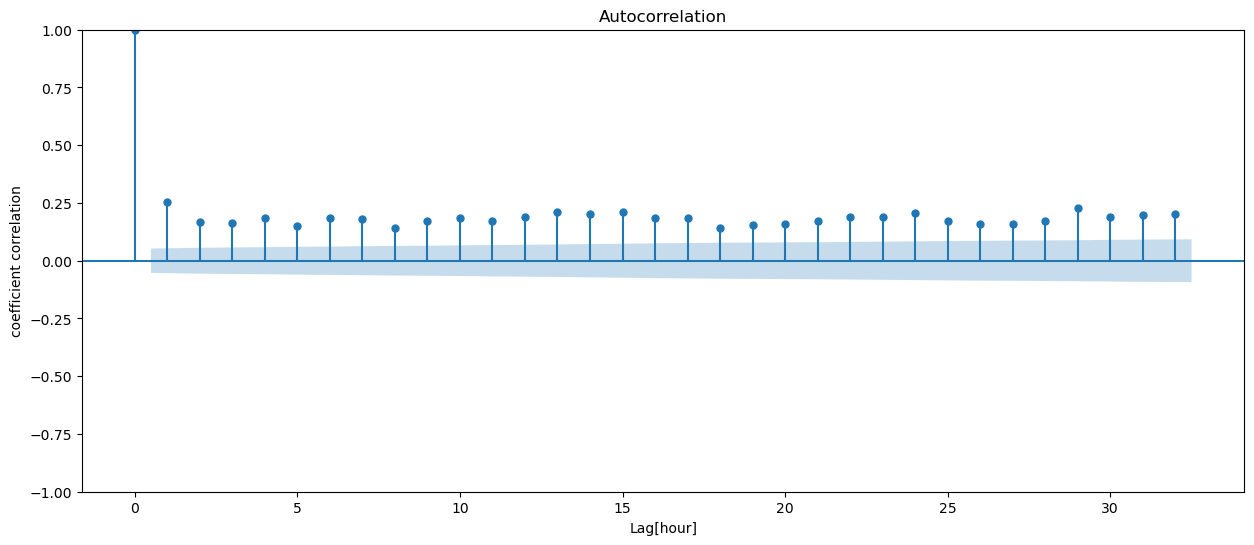

In [12]:
#used to check for the echo
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(df,ax=ax)
plt.xlabel("Lag[hour]")
plt.ylabel("coefficient correlation");

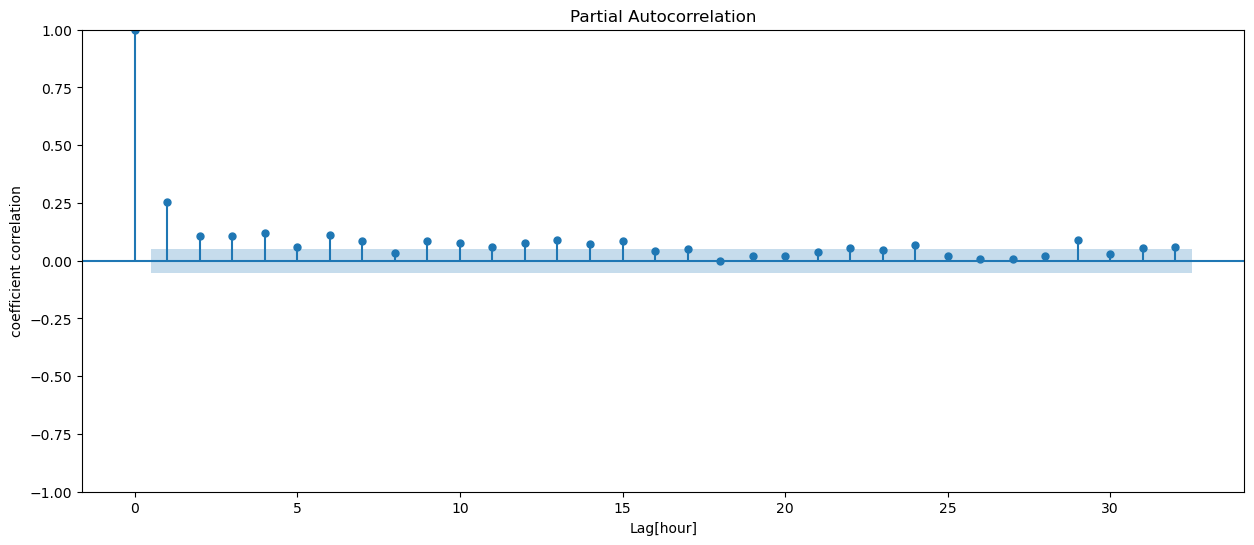

In [13]:
#used to check for the echo
fig,ax=plt.subplots(figsize=(15,6))
plot_pacf(df,ax=ax)
plt.xlabel("Lag[hour]")
plt.ylabel("coefficient correlation");

**Split my data**

In [14]:
df = df.reset_index()

In [15]:
# Split data
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [16]:
print(train_df.columns)

Index(['ds', 'y'], dtype='object')


In [17]:
train_df.head(5)

,ds,y
0,2024-03-01 15:50:05,38.7
1,2024-03-01 19:22:05,38.7
2,2024-03-01 20:18:01,38.7
3,2024-03-01 19:02:08,38.7
4,2024-03-01 22:01:08,38.7


**Build The model**

*Build a baseline*

In [36]:
y_predict =train_df["y"].mean()*len(train_df)
print(y_predict)

35200.82000000001


In [19]:
model = Prophet(changepoint_prior_scale=0.1)
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_df);

18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future = model.make_future_dataframe(periods=len(test_df), freq="D")  # Adjust freq if needed

In [21]:
forecast = model.predict(future)

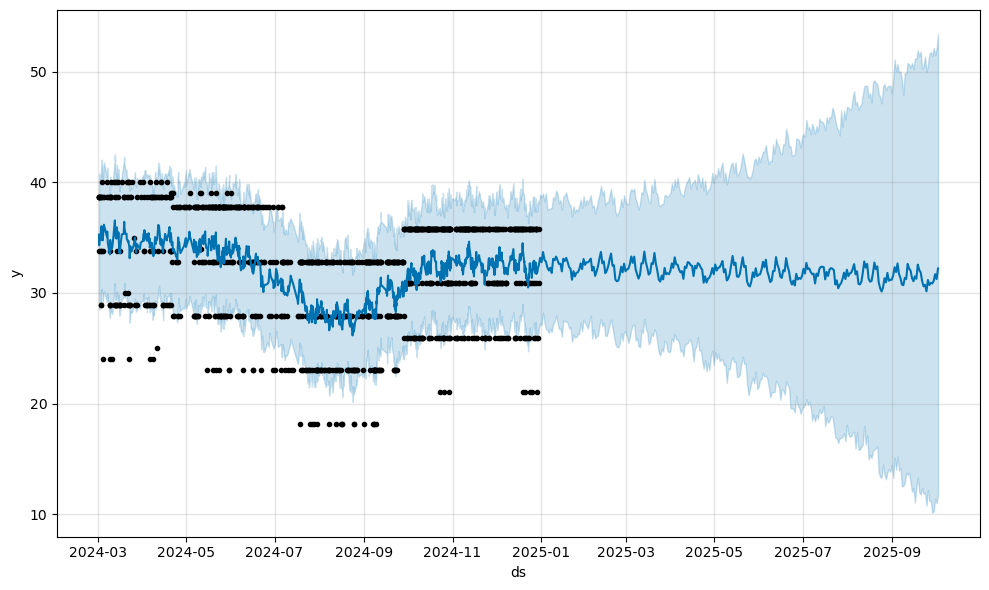

In [22]:
fig = model.plot(forecast)
plt.show()

In [38]:
# Convert both to datetime format (ensuring consistency)
test_df = test_df.copy()  # Create a deep copy to avoid warnings
forecast = forecast.copy()

test_df['ds'] = pd.to_datetime(test_df['ds']).dt.date
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.date

# Ensure test_df['ds'] exists in forecast
common_dates = test_df['ds'].isin(forecast['ds'])

# Extract only the test period from the forecasted data
test_forecast = forecast[['ds', 'yhat']].set_index('ds').loc[test_df.loc[common_dates, 'ds']]

# Create a comparison dataframe
comparison_df = test_df.loc[common_dates].set_index('ds').copy()
comparison_df['Predicted'] = test_forecast['yhat']

# Reset index for a clean table
comparison_df = comparison_df.reset_index()

# Display first few rows
print(comparison_df.head(10))



           ds      y  Predicted
0  2024-12-31  35.76  33.166407
1  2024-12-31  30.86  33.166407
2  2024-12-31  35.76  33.166407
3  2024-12-31  35.76  33.166407
4  2024-12-31  35.76  33.166407
5  2024-12-31  35.76  33.166407
6  2025-01-02  25.96  33.688986
7  2025-01-03  25.96  32.979722
8  2025-01-03  30.86  32.979722
9  2025-01-03  35.76  32.979722


In [39]:
mae = mean_absolute_error(comparison_df['y'], comparison_df['Predicted'])
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['Predicted']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 4.02
RMSE: 4.62


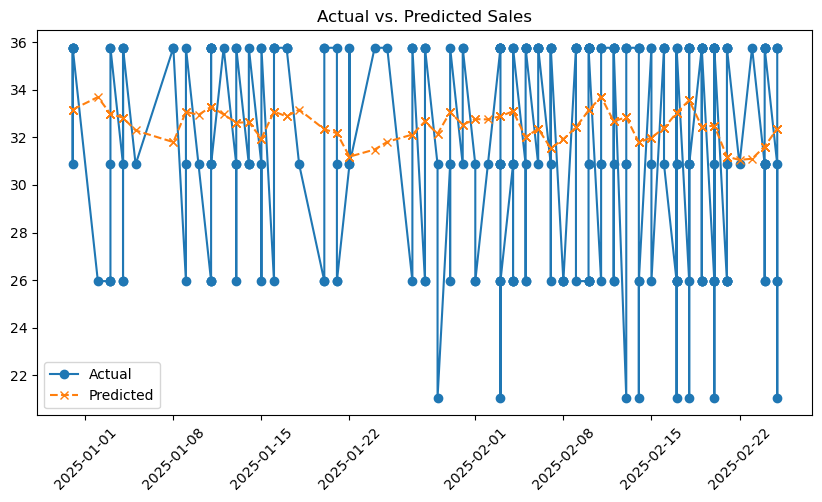

In [40]:
plt.figure(figsize=(10,5))
plt.plot(comparison_df['ds'], comparison_df['y'], label="Actual", marker='o')
plt.plot(comparison_df['ds'], comparison_df['Predicted'], label="Predicted", linestyle='dashed', marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title("Actual vs. Predicted Sales")
plt.show()